# Fishing Effort in the Mascarene Plateau

In [2]:

import bq  
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import matplotlib.dates as mdates

client = bq.Client.Get()

In [86]:
# create a bounding box:
max_lat = -5
min_lat = -15
max_lon = 65
min_lon = 55


In [3]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [10]:
q = '''
select count(distinct mmsi) 
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5'''

number_of_mmsi = Query(q)

Waiting on bqjob_r1734ade2e9e87c95_000001533982596c_3 ... (6s) Current status: DONE   
Query time: 9.14311790466 seconds.


In [8]:
print "Number of unique MMSI:",int(number_of_mmsi[0][0])

Number of unique MMSI: 190


# 190 MMSI were fishing in this region from January 2014 to June 2015

In [19]:
q = '''
select a.mmsi mmsi,
a.number number,
b.country country,
b.continent continent
from
(select mmsi, 
integer(if(length(string(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code,
count(*) number from
(SELECT
  mmsi,
  date(timestamp) date,
  first(latitude) lat,
  first(longitude) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > -15
  AND latitude <-5
  AND longitude > 55
  AND longitude <65
  AND weight >=.5
group by mmsi, date) 
group by mmsi, code 
) 
a
join [scratch_roan.country_code] b
on a.code = b.code 
order by number desc'''

days_by_mmsi = Query(q)

Waiting on bqjob_r7cd096493677b16c_00000153399d740c_7 ... (0s) Current status: DONE   
Query time: 1.76888108253 seconds.


# The List of MMSI that were fishing are below

In [77]:
for r in days_by_mmsi:
    if "Taiwan" in r[2]:
        r[2] = "Taiwan"
    print "mmsi:", r[0],"  fishing days:", r[1], "  country: ", r[2].split(" (")[0]

mmsi: 416000000   fishing days: 257   country:  Taiwan
mmsi: 416237800   fishing days: 115   country:  Taiwan
mmsi: 416002566   fishing days: 105   country:  Taiwan
mmsi: 416002655   fishing days: 97   country:  Taiwan
mmsi: 416241800   fishing days: 96   country:  Taiwan
mmsi: 416001838   fishing days: 96   country:  Taiwan
mmsi: 416214600   fishing days: 96   country:  Taiwan
mmsi: 416239800   fishing days: 91   country:  Taiwan
mmsi: 525000000   fishing days: 79   country:  Indonesia
mmsi: 416004367   fishing days: 77   country:  Taiwan
mmsi: 416236600   fishing days: 74   country:  Taiwan
mmsi: 416002039   fishing days: 70   country:  Taiwan
mmsi: 416002767   fishing days: 69   country:  Taiwan
mmsi: 416229900   fishing days: 69   country:  Taiwan
mmsi: 416004187   fishing days: 66   country:  Taiwan
mmsi: 416002508   fishing days: 65   country:  Taiwan
mmsi: 416004773   fishing days: 59   country:  Taiwan
mmsi: 416244700   fishing days: 55   country:  Taiwan
mmsi: 533333001   fish

In [22]:
# Now Group by Country
q = '''
SELECT 
country,
sum(number) number
from
(select a.mmsi mmsi,
a.number number,
b.country country,
b.continent continent
from
(select mmsi, 
integer(if(length(string(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code,
count(*) number from
(SELECT
  mmsi,
  date(timestamp) date,
  first(latitude) lat,
  first(longitude) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
group by mmsi, date) 
group by mmsi, code 
) 
a
join [scratch_roan.country_code] b
on a.code = b.code)
group by country
order by number desc'''

country_groups = Query(q)

Waiting on bqjob_r46402e92e9344f10_0000015339a084c9_8 ... (3s) Current status: DONE   
Query time: 5.62270903587 seconds.


In [31]:
print "days\tcountry"
for c in country_groups:
    print c[1],'\t', c[0].split(" (")[0]

days	country
3305 	Taiwan
160 	Malaysia
108 	Seychelles
89 	Reunion
86 	Indonesia
65 	Korea
52 	Belize
40 	China
38 	Mauritius
27 	Japan
27 	Panama
26 	Spain
21 	Oman
17 	Italy
11 	Philippines
10 	Vanuatu
10 	France
1 	Malta


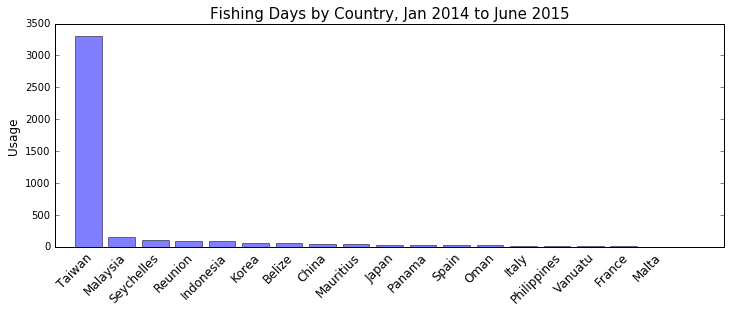

In [83]:
objects = [c[0].split(" (")[0] for c in country_groups]
y_pos = np.arange(len(objects))
performance = [c[1] for c in country_groups]
 
plt.figure(figsize=(12,4))
plt.bar(y_pos-4, performance, align='center', alpha=0.5,)
plt.xticks(y_pos-4+.2, objects, fontsize=12) # rotation=45
locs, labels = plt.xticks()
plt.setp(labels, rotation=45,ha='right')
plt.ylabel('Usage',fontsize=12)
plt.title('Fishing Days by Country, Jan 2014 to June 2015',fontsize=15)
ax = plt.axes()
ax.xaxis.set_ticks_position('none') 
plt.show()

# Map the Fishing Effort in This Region

In [87]:
# Now Group by Country
q = '''
SELECT
lat,
lon,
count(*) fishing_days
from
(SELECT
  mmsi,
  date(timestamp) date,
  integer(first(latitude)*4) lat,
  integer(first(longitude)*4) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
group by mmsi, date) 
group by lat, lon
'''

fishing_grid = Query(q)

Waiting on bqjob_r5ccc58aa5d57fb82_0000015339bcd28d_10 ... (0s) Current status: DONE   
Query time: 1.82012200356 seconds.


In [90]:
cellsize = .25
one_over_cellsize = 4

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = int(row[2])

41